In [2]:
from ripser import ripser
from persim import wasserstein
import numpy as np
import pandas as pd

D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

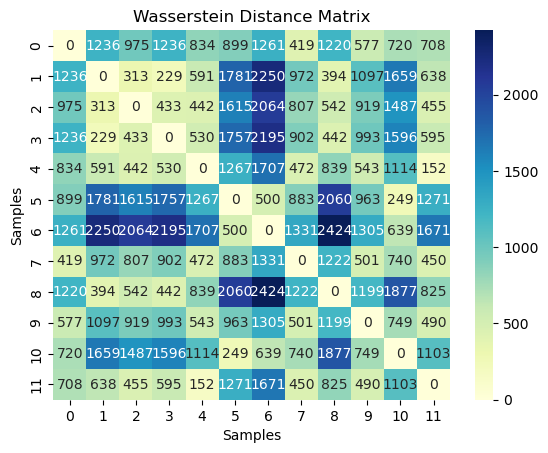

In [6]:
import pandas as pd
import numpy as np
from ripser import ripser
from persim import wasserstein
import os

# Step 1: Load the CSV files
file_paths = [
    "LanB1_270317.csv",
    "LanB1_280317A.csv",
    "LanB1_280317B.csv",
    "LanB1_300317.csv",
    "Control_130117.csv",
    "Control_140117.csv",
    "Control_191216.csv",
    "Control_201216.csv",
    "Scar_130117.csv",
    "Scar_140117.csv",
    "Scar_151216.csv",
    "Scar_201216.csv"
]

# Step 2: Extract the point clouds at Time = 400
point_clouds = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    # Filter rows where Time = 400 and select relevant coordinates
    points_at_400 = df[df["Time"] == 200][['Position X', 'Position Y', 'Position Z']].values  # Adjust column names if needed
    point_clouds.append(points_at_400)

# Step 3: Compute persistence diagrams
diagrams_list = [ripser(pc)['dgms'] for pc in point_clouds]

# Step 4: Compute the Wasserstein distance matrix
n_samples = len(diagrams_list)
wasserstein_matrix = np.zeros((n_samples, n_samples))

for i in range(n_samples):
    for j in range(i, n_samples):
        # Compute Wasserstein distance for H0
        distance = wasserstein(diagrams_list[i][0], diagrams_list[j][0])
        wasserstein_matrix[i, j] = distance
        wasserstein_matrix[j, i] = distance  # Symmetric matrix

# Step 5: Display the Wasserstein matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(wasserstein_matrix, annot=True, cmap="YlGnBu", fmt=".0f")
plt.title("Wasserstein Distance Matrix")
plt.xlabel("Samples")
plt.ylabel("Samples")
plt.show()


In [3]:
import numpy as np

# Assuming wasserstein_matrix is your distance matrix
upper_triangular_distances = wasserstein_matrix[np.triu_indices_from(wasserstein_matrix, k=1)]

mean_distance = np.mean(upper_triangular_distances)
std_distance = np.std(upper_triangular_distances)

print(f"Mean Distance: {mean_distance:.2f}")
print(f"Standard Deviation of Distances: {std_distance:.2f}")


Mean Distance: 796.95
Standard Deviation of Distances: 459.55


In [4]:
threshold = mean_distance + 2 * std_distance
large_distances = np.where(upper_triangular_distances > threshold)

print(f"Pairs with 'large' distances (above threshold of {threshold:.2f}):")
for idx in zip(*np.triu_indices_from(wasserstein_matrix, k=1)):
    if wasserstein_matrix[idx] > threshold:
        print(f"Samples {idx[0]} and {idx[1]}: Distance = {wasserstein_matrix[idx]:.2f}")


Pairs with 'large' distances (above threshold of 1716.06):
Samples 0 and 5: Distance = 1788.79


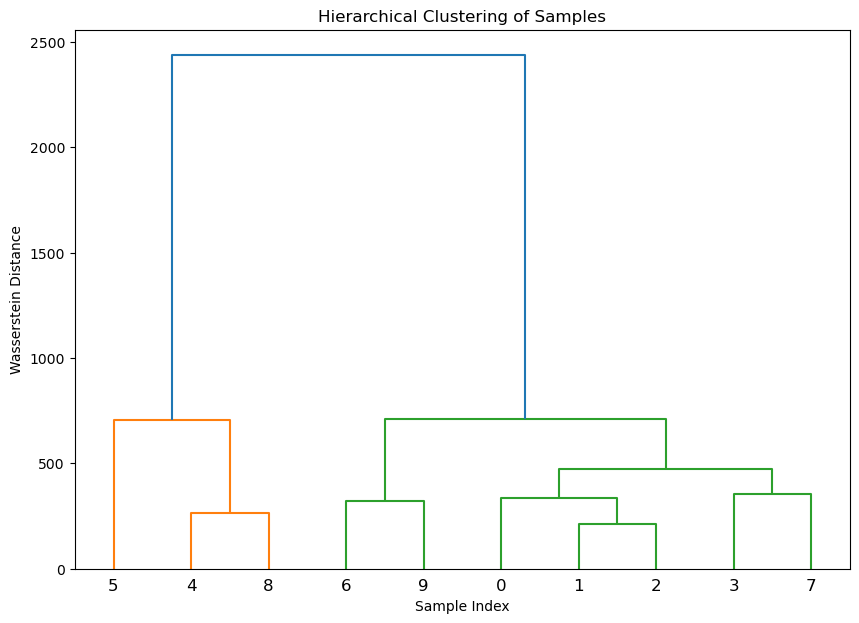

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linkage_matrix = linkage(upper_triangular_distances, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=np.arange(len(wasserstein_matrix)))
plt.title("Hierarchical Clustering of Samples")
plt.xlabel("Sample Index")
plt.ylabel("Wasserstein Distance")
plt.show()


In [31]:
import point_cloud_utils as pcu
import numpy as np

# Generate two random point sets
a = np.random.rand(1000, 3)
b = np.random.rand(500, 3)

# Compute one-sided squared Hausdorff distances
hausdorff_a_to_b = pcu.one_sided_hausdorff_distance(a, b)
hausdorff_b_to_a = pcu.one_sided_hausdorff_distance(b, a)

# Take a max of the one sided squared  distances to get the two sided Hausdorff distance
hausdorff_dist = pcu.hausdorff_distance(a, b)

In [32]:
print(pcu.hausdorff_distance(point_clouds[0], point_clouds[2]))

64.72061284923065


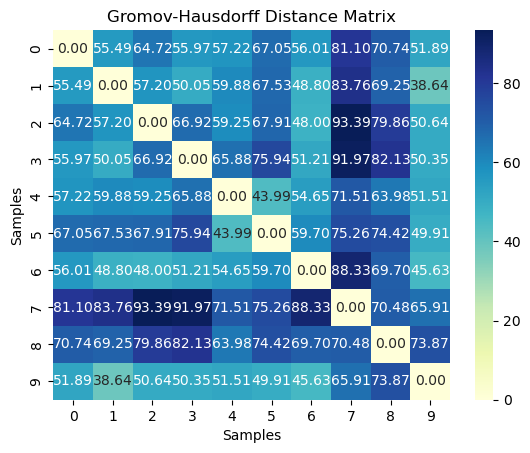

In [43]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def gromov_hausdorff_distance_matrix(samples):
    """
    Compute the Gromov-Hausdorff distance matrix for multiple samples.

    Parameters:
        samples (list of ndarray): List of point clouds, where each element is a 2D array.

    Returns:
        ndarray: Gromov-Hausdorff distance matrix.
    """
    n_samples = len(samples)
    gh_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(i, n_samples):
            # Compute Gromov-Hausdorff distance for samples i and j
            gh_matrix[i, j] = pcu.hausdorff_distance(samples[i], samples[j])
            gh_matrix[j, i] = gh_matrix[i, j]  # Symmetric matrix

    return gh_matrix

# Load point clouds from your datasets
# Assuming you have extracted point clouds for Time = 400 from your datasets
# Example: point_clouds = [np.array from dataset1, np.array from dataset2, ...]

# Example: Replace with your actual point clouds


# Compute the Gromov-Hausdorff distance matrix
gh_matrix = gromov_hausdorff_distance_matrix(point_clouds)

# Visualize the Gromov-Hausdorff distance matrix
sns.heatmap(gh_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Gromov-Hausdorff Distance Matrix")
plt.xlabel("Samples")
plt.ylabel("Samples")
plt.show()


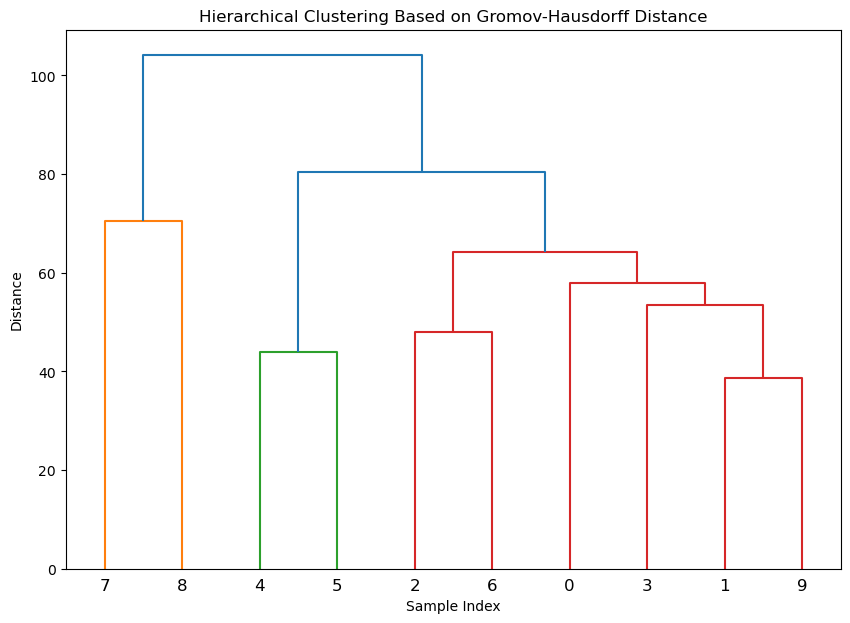

In [44]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Assuming `gh_matrix` is the Gromov-Hausdorff distance matrix
# Use a condensed version of the matrix for hierarchical clustering
from scipy.spatial.distance import squareform

# Convert the symmetric GH matrix to condensed form
gh_condensed = squareform(gh_matrix, checks=False)

# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(gh_condensed, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=np.arange(len(gh_matrix)))
plt.title("Hierarchical Clustering Based on Gromov-Hausdorff Distance")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()



In [36]:
import persim
print(persim.bottleneck(point_clouds[0], point_clouds[1]))

54.08600000000001


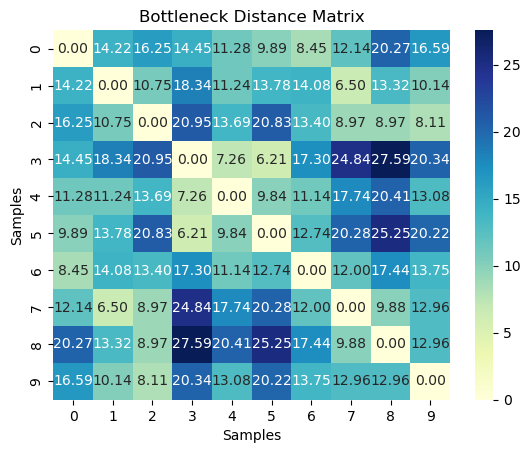

In [41]:
from ripser import ripser
from persim import bottleneck
from joblib import Parallel, delayed
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def compute_bottleneck_matrix(samples):
    """
    Compute the Bottleneck distance matrix for multiple persistence diagrams.

    Parameters:
        samples (list of ndarray): A list of point clouds (each is a 2D array).

    Returns:
        ndarray: Bottleneck distance matrix.
    """
    # Compute persistence diagrams for each point cloud
    diagrams = [ripser(sample)['dgms'] for sample in samples]

    # Define a function to compute bottleneck distance for a pair of diagrams
    def bottleneck_distance(i, j):
        return bottleneck(diagrams[i][1], diagrams[j][1])  

    n_samples = len(samples)
    distances = np.zeros((n_samples, n_samples))

    # Use parallel processing to compute pairwise bottleneck distances
    results = Parallel(n_jobs=-1)(
        delayed(bottleneck_distance)(i, j)
        for i in range(n_samples) for j in range(i, n_samples)
    )

    # Fill the distance matrix
    k = 0
    for i in range(n_samples):
        for j in range(i, n_samples):
            distances[i, j] = results[k]
            distances[j, i] = results[k]  # Symmetric matrix
            k += 1

    return distances

# Example point clouds (replace with your actual data)

# Compute the Bottleneck distance matrix
bottleneck_matrix = compute_bottleneck_matrix(point_clouds)

# Visualize the Bottleneck distance matrix
sns.heatmap(bottleneck_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Bottleneck Distance Matrix")
plt.xlabel("Samples")
plt.ylabel("Samples")
plt.show()


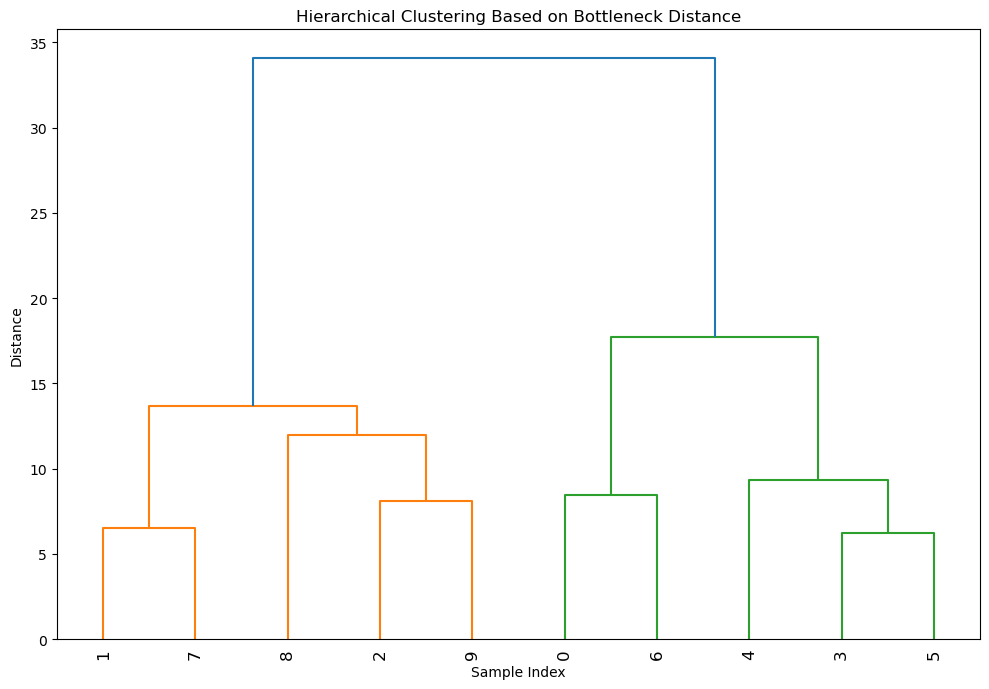

In [42]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# Assuming 'bottleneck_matrix' is your Bottleneck distance matrix
# Ensure that 'bottleneck_matrix' is a NumPy array
# For example, if you computed it as shown previously:
# bottleneck_matrix = compute_bottleneck_matrix(point_clouds)

# Since the distance matrix is square and symmetric, convert it to a condensed distance matrix
# suitable for hierarchical clustering functions.
# The 'squareform' function converts a square matrix to a condensed form.

# Remove the diagonal elements and flatten the upper triangular part
condensed_dist_matrix = squareform(bottleneck_matrix, checks=False)

# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(condensed_dist_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linkage_matrix,
    labels=np.arange(len(bottleneck_matrix)),
    leaf_rotation=90,  # Rotates the x-axis labels for better readability
    leaf_font_size=12  # Font size for the x-axis labels
)
plt.title("Hierarchical Clustering Based on Bottleneck Distance")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
from ripser import ripser
import matplotlib.pyplot as plt
from persim import plot_diagrams, wasserstein

# Step 1: Generate a 2D Gaussian point cloud
def generate_gaussian_point_cloud(mean, cov, n_points):
    """
    Generate a 2D Gaussian-distributed point cloud.

    Parameters:
        mean (list or ndarray): Mean of the Gaussian distribution [x_mean, y_mean].
        cov (list or ndarray): Covariance matrix [[var_x, cov_xy], [cov_xy, var_y]].
        n_points (int): Number of points to generate.

    Returns:
        ndarray: Generated 2D point cloud (shape: n_points x 2).
    """
    return np.random.multivariate_normal(mean, cov, n_points)

# Parameters for the Gaussian distribution
mean = [0, 0]  # Centered at origin
cov = [[100, 0], [0, 100]]  # Identity covariance (independent, unit variance)
n_points = 240  # Number of points

# Generate the point cloud
gaussian_point_cloud = generate_gaussian_point_cloud(mean, cov, n_points)

# Plot the generated point cloud
plt.scatter(gaussian_point_cloud[:, 0], gaussian_point_cloud[:, 1], s=5, alpha=0.7)
plt.title("2D Gaussian Point Cloud")
plt.xlabel("X") plt.ylabel("Y")
plt.axis("equal")
plt.show()

# Step 2: Compute the persistence diagram for the Gaussian point cloud
gaussian_diagram = ripser(gaussian_point_cloud)['dgms']

# Plot the persistence diagram
plot_diagrams(gaussian_diagram, title="Persistence Diagram for Gaussian Point Cloud")

# Step 3: Compare with previous samples
# Assuming `diagrams_list` contains persistence diagrams of previous samples
# Replace with your actual list of persistence diagrams

# Compute the Bottleneck distances
for i, diagram in enumerate(diagrams_list):
    distance = wasserstein(diagram[0], gaussian_diagram[0])  # Compare H0 diagrams
    print(f"Wasserstein distance between Gaussian diagram and Sample {i+1}: {distance:.4f}")


SyntaxError: invalid syntax (3442643208.py, line 32)

In [5]:
import pandas as pd
import numpy as np
from ripser import ripser
from persim import wasserstein

def compute_cross_wasserstein_matrix(file_paths, time_start, time_end):
    """
    Compute cross Wasserstein distance matrices for all time steps from time_start to time_end.

    Parameters:
        file_paths (list of str): List of file paths for the datasets.
        time_start (int): Start time for iteration.
        time_end (int): End time for iteration.

    Returns:
        dict: A dictionary with time steps as keys and Wasserstein matrices as values.
    """
    # Dictionary to store Wasserstein matrices for each time step
    wasserstein_matrices = {}

    # Iterate through each time step
    for t in range(time_start, time_end + 1):
        point_clouds = []
        print(point_clouds)

        # Step 1: Extract point clouds for each file at the current time step
        for file_path in file_paths:
            df = pd.read_csv(file_path)
            # Filter rows where Time = t and select relevant coordinates
            points_at_t = df[df["Time"] == t][['Position X', 'Position Y', 'Position Z']].values  # Adjust column names if needed
            point_clouds.append(points_at_t)
            

        # Step 2: Compute persistence diagrams for all point clouds
        diagrams_list = [ripser(pc)['dgms'] for pc in point_clouds]

        # Step 3: Compute the Wasserstein distance matrix for the current time step
        n_samples = len(diagrams_list)
        wasserstein_matrix = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(i, n_samples):
                # Compute Wasserstein distance for H0
                distance = wasserstein(diagrams_list[i][0], diagrams_list[j][0])
                wasserstein_matrix[i, j] = distance
                wasserstein_matrix[j, i] = distance  # Symmetric matrix

        # Store the Wasserstein matrix for the current time step
        wasserstein_matrices[t] = wasserstein_matrix

    return wasserstein_matrices

# Example usage:
# file_paths = ["file1.csv", "file2.csv", ...]
# Replace with actual file paths

# Compute the Wasserstein matrices from t = 0 to t = 400
time_start, time_end = 1, 400
wasserstein_matrices = compute_cross_wasserstein_matrix(file_paths, time_start, time_end)

# Example: Access the Wasserstein matrix for a specific time step (e.g., t = 50)
t = 50
if t in wasserstein_matrices:
    print(f"Wasserstein matrix at t = {t}:")
    print(wasserstein_matrices[t])
else:
    print(f"No data for t = {t}")


[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

[]


D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points wit

Wasserstein matrix at t = 50:
[[   0.          275.41614332  345.4501029   393.32817827 1082.43547486
  1371.99009085  239.81515852  497.79974401 1166.34721503  526.58204358]
 [ 275.41614332    0.          276.75398101  203.70537555  932.35930691
  1204.74301466  254.91383037  294.26686066 1017.00682336  316.89754289]
 [ 345.4501029   276.75398101    0.          362.33362398  774.4990194
  1071.93205523  279.8750352   435.3495129   857.17078992  308.96566483]
 [ 393.32817827  203.70537555  362.33362398    0.          964.02444014
  1287.16745424  302.80426219  177.91305269 1046.65906905  315.72149029]
 [1082.43547486  932.35930691  774.4990194   964.02444014    0.
   583.02987249  925.10372154  946.39538904  174.30848993  699.16484779]
 [1371.99009085 1204.74301466 1071.93205523 1287.16745424  583.02987249
     0.         1285.63251813 1325.66069766  694.3673193  1071.8008153 ]
 [ 239.81515852  254.91383037  279.8750352   302.80426219  925.10372154
  1285.63251813    0.          347.35

D:\anaconda\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
D:\anaconda\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


In [6]:
print(wasserstein_matrices)

{1: array([[   0.        ,  154.68873273,  206.6419239 , 1250.64936055,
         476.194602  ,  957.12129645,  397.83203695,  548.54319592,
         357.88118713,  339.93755822],
       [ 154.68873273,    0.        ,  192.96387464, 1354.54924248,
         440.36606877,  870.20070753,  480.84377099,  652.96894857,
         383.38515535,  419.35281323],
       [ 206.6419239 ,  192.96387464,    0.        , 1392.4875211 ,
         370.95549853,  818.02111167,  559.47234812,  710.82165467,
         369.49373452,  480.01510111],
       [1250.64936055, 1354.54924248, 1392.4875211 ,    0.        ,
        1532.88347783, 2067.48781969,  937.27657759,  725.13875976,
        1315.32627263,  962.24077254],
       [ 476.194602  ,  440.36606877,  370.95549853, 1532.88347783,
           0.        ,  548.60239832,  808.6889342 ,  855.93461614,
         264.25770129,  690.62198612],
       [ 957.12129645,  870.20070753,  818.02111167, 2067.48781969,
         548.60239832,    0.        , 1279.59790418, 

In [20]:
import csv

# Sample dictionary
data = wasserstein_matrices

# Specify the file name
filename = 'output.csv'

# Writing to CSV file
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(data.keys())
    
    # Write the data
    writer.writerows(zip(*data.values()))

print(f"Data has been successfully saved to {filename}")



Data has been successfully saved to output.csv


In [3]:
df = pd.read_csv('reshaped_integer_output_fixed.csv')
print(df)

             0           1           2           3           4           5  \
0     1.000000    2.000000    3.000000    4.000000    5.000000    6.000000   
1     1.000000    2.000000    3.000000    4.000000    5.000000    6.000000   
2     1.000000    2.000000    3.000000    4.000000    5.000000    6.000000   
3     1.000000    2.000000    3.000000    4.000000    5.000000    6.000000   
4     1.000000    2.000000    3.000000    4.000000    5.000000    6.000000   
..         ...         ...         ...         ...         ...         ...   
95  773.958764  772.810448  723.423159  773.228987  698.060106  722.642212   
96  638.528171  655.377466  653.060040  673.179617  610.466406  644.971185   
97  662.422593  699.359156  728.196473  742.237397  711.099201  760.302026   
98    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
99  515.620320  554.011632  559.143363  541.575454  499.509582  498.698880   

             6           7           8           9  ...        

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the reshaped 2D matrix from the CSV file
file_path = "output.csv"  # Replace with the path to your local file
data = pd.read_csv(file_path, header=None).values

# Assuming the data was reshaped from a 3D (time, n_entries, n_entries) matrix into a 2D matrix
n_entries = int(np.sqrt(data.shape[1]))  # Number of entries (matrix size)
n_timesteps = data.shape[0]  # Number of timesteps
print(n_entries)
# Reshape the data back into a 3D form: (time, n_entries, n_entries)
wasserstein_matrices = data.reshape((n_timesteps, n_entries, n_entries))

# Compute the cumulative and average Wasserstein distances
cumulative_distances = np.sum(wasserstein_matrices, axis=0)
average_distances = cumulative_distances / n_timesteps

# Find the most similar pair (smallest average distance)
min_distance = np.inf
closest_pair = None

for i in range(n_entries):
    for j in range(i + 1, n_entries):  # Only look at upper triangle
        if average_distances[i, j] < min_distance:
            min_distance = average_distances[i, j]
            closest_pair = (i, j)

# Output results
print(f"The most similar pair over all timesteps is: {closest_pair}")
print(f"Their average Wasserstein distance is: {min_distance:.4f}")

# Optional: Visualize the average Wasserstein distance matrix
sns.heatmap(average_distances, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Average Wasserstein Distance Matrix")
plt.xlabel("Entry Index")
plt.ylabel("Entry Index")
plt.show()


20


TypeError: unsupported operand type(s) for /: 'str' and 'int'